# 데이터 JSON파일 형식 변경
- **YOLOv5에서의 라벨링 데이터 형식(txt파일)**
```
{class_num} {center of X}, {center of Y}, {width}, {height}
```
- **원본 데이터의 라벨링 데이터(json파일)**

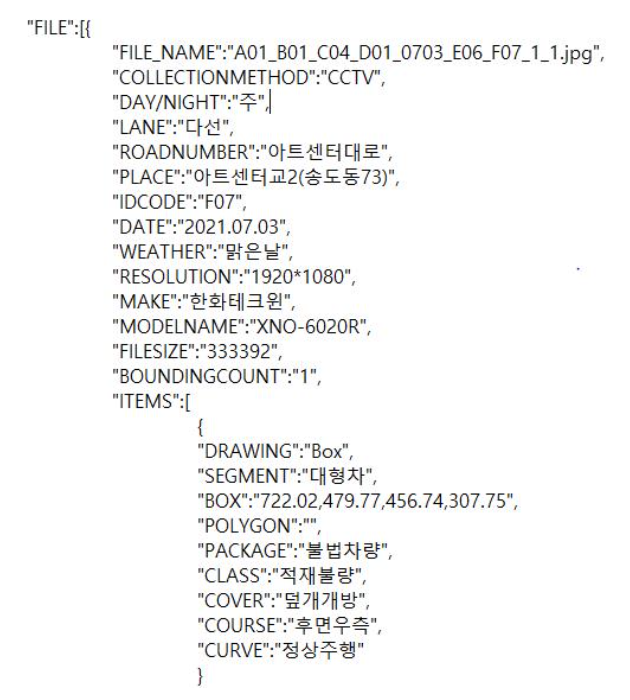

`BOX`좌표가 바운딩 박스의 좌표를 의미한다.<br>이때, 원본 데이터의 경우 X1(Box 좌측 x좌표),Y1(Box하단 y좌표),width,height이기 때문에 다음과 같은 연산을 통해서 좌표를 변경해주어야 한다.<br>

$x-center = (x1+x2\div2)\div RESOLUTION[0] $<br>
$y-ceter = (y1+y2\div2)\div RESOLUTION[1] $<br>
$weidth = x2 \div RESOLUTION[0]$<br>
$height = y2 \div RESOLUTION[1]$

`RESOLUTION`을 나눠주는 이유는 bounding box의 정보는 이미지 사이즈에 의하여 정규화되어야 하기 때문이다.


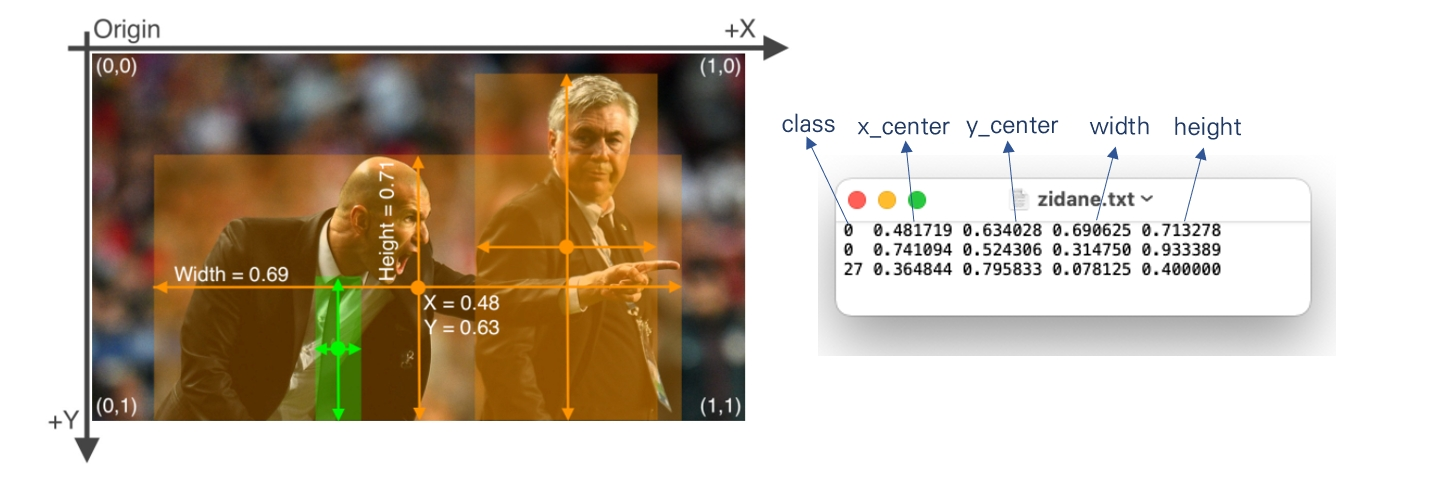

- 출처: https://sguys99.github.io/ds01

### 수정에 앞서 주의사항
기본적으로 파일의 디렉토리명은 Windows기준에서 작성된 것 같습니다.<br>
따라서 MacOS에서 파일을 불러서 사용하게 되면 아래와 같이 파일 디렉토리 명이 일치하지 않는 에러가 발생합니다.<br>

따라서 Mac 환경에서 작업할 시 파일 명을 영어로 한번 수정한 후에 불러와서 사용하는 것을 추천드립니다. 이와 반대로 Windows에서는 Mac환경에서 작성된 한글파일을 사용하면 동일한 오류가 발생할 것이기 때문에 이 역시, 같은 방법으로 해결할 수 있습니다.<br>

단, OS, glob과 같은 라이브러리 안에서 사용할 시에는 영향을 받지 않는 것 같습니다.

In [ ]:
"정상차량" == "정상차량"

False

In [ ]:
len("정상차량") # 파일이름을 그대로 복사하였을 시

11

In [ ]:
len("정상차량") # 직접 입력시

4

## 구글 드라이브 연동 및 데이터 파일 불러오기
사용 데이터는 다음 링크에서 다운로드 받으실 수 있습니다.<br>
다운로드 후 구글 드라이브에 업로드 해서 사용해주세요.

- **sample data다운로드 링크:https://drive.google.com/file/d/1dBRepCdseBFihGXNzb3q1MZsdm-lsgW3/view?usp=share_link**

- **원본 데이터: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=530**

sample 데이터 역시 원본 데이터 링크에서 다운로드 받으실 수 있습니다.

sample데이터의 경우 원본데이터에서 validation파일에 저장된 `대형차`,`중형차`에 대한 이미지와 라벨을 다운받아 사용하였습니다.

In [1]:
from google.colab import output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/New_Data.zip
output.clear()

In [4]:
# 각 데이터셋의 크기 확인
from glob import glob

nomal_img_list = glob('/content/New_Data/origin/big/normal/*.jpg')
illegal_img_list = glob('/content/New_Data/origin/big/illegal/*.jpg')
nomal_label_list = glob('/content/New_Data/labels/big/normal/*.json')
illegal_label_list = glob('/content/New_Data/labels/big/illegal/*.json')
print(len(nomal_img_list),len(illegal_img_list),len(nomal_label_list), len(illegal_label_list))

nomal_img_list = glob('/content/New_Data/origin/middle/normal/*.jpg')
illegal_img_list = glob('/content/New_Data/origin/middle/illegal/*.jpg')
nomal_label_list = glob('/content/New_Data/labels/middle/normal/*.json')
illegal_label_list = glob('/content/New_Data/labels/middle/illegal/*.json')
print(len(nomal_img_list),len(illegal_img_list),len(nomal_label_list), len(illegal_label_list))

6236 3211 6236 3211
6095 6824 6095 6824


In [5]:
import json
import os

# JSON 파일 경로
json_file = "/content/New_Data/labels"

# 수정한 라벨링 데이터 파일 저장 경로생성 및 지정
os.makedirs('/content/new_labels/normal',exist_ok=True)
os.makedirs('/content/new_labels/illegal',exist_ok=True)
store = '/content/new_labels'

# JSON 파일 열기 및 수정하기
for car_type in os.listdir(json_file):
    car_path = os.path.join(json_file, car_type)
    for label_type in os.listdir(car_path):
        label_path = os.path.join(car_path, label_type)
        store_path = os.path.join(store, label_type)
        # JSON파일 열기
        for filename in os.listdir(label_path):
            json_path = os.path.join(label_path, filename)
            with open(json_path, 'r') as f:
                data = json.load(f)
                items = data['FILE'][0]['ITEMS']
                img_width, img_height = map(int, data['FILE'][0]['RESOLUTION'].split("*"))
                label_dict = {'불법차량': 0, '정상차량': 1}  # 클래스 ID 매핑 정보
                n = 0
                # 수정할 데이터 접근
                for item in items:
                    class_name = item["PACKAGE"]
                    class_id = label_dict[class_name]
                    box = item['BOX'].split(',')
                    x1,y1,x2,y2 = float(box[0]), float(box[1]), float(box[2]), float(box[3])
                    x = (x1+x2/2)/(img_width)    # Center of x
                    y = (y1+y2/2)/(img_height)   # Center of y
                    w = x2/img_width     # width
                    h = y2/img_height    # height

                    yolo_label = f"{class_id} {x} {y} {w} {h}"
                    n += 1
                    # 숫자들을 저장할 txt 파일 생성 및 쓰기
                    if n == 1:
                        with open(os.path.join(store_path,filename.replace('.json', '.txt')), 'w') as f:
                                f.write(yolo_label)
                    else:
                        with open(os.path.join(store_path,filename.replace('.json', '.txt')), 'a') as f:
                                f.write('\n'+yolo_label)


제대로 불러와졌는지 데이터 크기 확인

In [6]:
# 각 데이터셋의 크기 확인
nomal_label_list = glob('/content/new_labels/normal/*.txt')
illegal_label_list = glob('/content/new_labels/illegal/*.txt')
print(len(nomal_label_list), len(illegal_label_list))

12331 10035


# 데이터 파일 구조 조정하기
YOLOv5가 요구하는 데이터 파일 디렉토리의 구조는 다음과 같습니다.
```
Data_file
├── train
│   └── images
│   └── labels
├── valid
│   └── images
│   └── labels
├── test
│   └── images
│   └── labels
├── data.yaml
```


In [7]:
from sklearn.model_selection import train_test_split # dataset분할
import shutil # 파일 복사와 삭제 지원

# 원본 이미지와 라벨링이 들어있는 폴더 경로
label_data_dir = "/content/new_labels"

# 각 데이터 세트를 저장할 폴더 경로
data_set_dir = "/content/dataset"
os.makedirs(os.path.join(data_set_dir, "train/images"),exist_ok=True)
os.makedirs(os.path.join(data_set_dir, "train/labels"),exist_ok=True)
os.makedirs(os.path.join(data_set_dir, "valid/images"),exist_ok=True)
os.makedirs(os.path.join(data_set_dir, "valid/labels"),exist_ok=True)
os.makedirs(os.path.join(data_set_dir, "test/images"),exist_ok=True)
os.makedirs(os.path.join(data_set_dir, "test/labels"),exist_ok=True)

# 불법차량과 정상차량을 나누기 위한 리스트
illegal_cars = []
normal_cars = []

# 불법차량과 정상차량 분류
for label_type in os.listdir(label_data_dir):
    label_path = os.path.join(label_data_dir, label_type)
    n = 0
    for filename in os.listdir(label_path):
        if label_type == "illegal":
            illegal_cars.append(filename)
        elif label_type == "normal":
            normal_cars.append(filename)

# 데이터셋 분할 비율
train_len = int(len(illegal_cars)*0.6)
val_test_len = int(len(illegal_cars)*0.2)

# Train, Valid, Test나누기
illegal_train, illegal_valid, illegal_test = illegal_cars[:train_len], illegal_cars[train_len:train_len+val_test_len], illegal_cars[train_len+val_test_len:]
normal_train, normal_valid, normal_test =normal_cars[:train_len], normal_cars[train_len:train_len+val_test_len], normal_cars[train_len+val_test_len:]

# 각각 합치기
data = {}
data['train'] = illegal_train + normal_train
data['valid'] = illegal_valid + normal_valid
data['test'] = illegal_test + normal_test

# 이미지 파일을 저장할 디렉토리
train_image_dir = '/content/dataset/train'
valid_image_dir = '/content/dataset/valid'
test_image_dir = '/content/dataset/test'

# 이미지 파일 경로
big_illegal_dir = '/content/New_Data/origin/big/illegal'
big_normal_dir = '/content/New_Data/origin/big/normal'
middle_illegal_dir = '/content/New_Data/origin/middle/illegal'
middle_normal_dir = '/content/New_Data/origin/middle/normal'

for cat_data, filenames in data.items():
    if cat_data == 'train':
        dir_path = train_image_dir
    elif cat_data == 'valid':
        dir_path = valid_image_dir
    elif cat_data == 'test':
        dir_path = test_image_dir
    else:
        break
  
    for filename in filenames:
        # illegal 디렉토리 안에서 이미지 파일을 찾는 경우
        if os.path.exists(os.path.join(big_illegal_dir,filename.replace('.txt','.jpg'))):
            shutil.copy(os.path.join(big_illegal_dir, filename.replace('.txt','.jpg')), os.path.join(dir_path+'/images', filename.replace('.txt','.jpg')))
            shutil.copy(os.path.join(label_data_dir+'/illegal', filename), os.path.join(dir_path+'/labels', filename)) # txt파일은 labels에 저장
        elif os.path.exists(os.path.join(middle_illegal_dir,filename.replace('.txt','.jpg'))):
            shutil.copy(os.path.join(middle_illegal_dir, filename.replace('.txt','.jpg')), os.path.join(dir_path+'/images', filename.replace('.txt','.jpg')))
            shutil.copy(os.path.join(label_data_dir+'/illegal', filename), os.path.join(dir_path+'/labels', filename)) # txt파일은 labels에 저장
        
        # normal 디렉토리 안에서 이미지 파일을 찾는 경우
        elif os.path.exists(os.path.join(big_normal_dir,filename.replace('.txt','.jpg'))):
            shutil.copy(os.path.join(big_normal_dir, filename.replace('.txt','.jpg')), os.path.join(dir_path+'/images', filename.replace('.txt','.jpg')))
            shutil.copy(os.path.join(label_data_dir+'/normal', filename), os.path.join(dir_path+'/labels', filename)) # txt파일은 labels에 저장
        elif os.path.exists(os.path.join(middle_normal_dir,filename.replace('.txt','.jpg'))):
            shutil.copy(os.path.join(middle_normal_dir, filename.replace('.txt','.jpg')), os.path.join(dir_path+'/images', filename.replace('.txt','.jpg')))
            shutil.copy(os.path.join(label_data_dir+'/normal', filename), os.path.join(dir_path+'/labels', filename)) # txt파일은 labels에 저장
        # illegal과 normal 디렉토리 모두에서 해당 이미지 파일을 찾지 못하는 경우
        else:
            print(f"{filename.replace('.txt','.jpg')} does not exist in illegal or normal directory!")



In [ ]:
# Background이미지 추가하기
!unzip /content/drive/MyDrive/background_image.zip
output.clear()

file_path = '/content/background_image'

for filename in os.listdir(file_path):
    shutil.copy(os.path.join(file_path, filename), os.path.join('/content/dataset/train/images',filename))

## Back-ground 이미지
Yolo5의 공식문서에 따르면 훈련이미지의 0~10%정도 양의 백그라운드 이미지(아무런 라벨이 없는 이미지)를 추가하는 것이 모델의 성능에 긍정적인 영향을 줄 수 있다고 제시되어있습니다.

이에 따라서 이번 모델에서 식별하고자하는 대형화물차, 중형화물차에 대한 정보가 담겨있지 않은 데이터를 수집하여 백그라운드 이미지로 학습데이터에 추가하였습니다.<br>

COCO데이터셋의 경우도 10%정도의 백그라운드 이미지를 가지고 있다고 합니다.
비율은 전체데이터의 크기에 따라서 달라지며 10%가 넘어서 훈련시킨 경우도 있지만 최종적인 결론만 제시하면 다음과 같습니다.
- 훈련데이터 크기: 12042
- 백그라운드 이미지: 198
- 총 훈련데이터셋 크기: 12240

In [8]:
train_image_list = glob('/content/dataset/train/images/*.jpg')
train_labels_list = glob('/content/dataset/train/labels/*.txt')
print(len(train_image_list),len(train_labels_list))

12042 12042


In [ ]:
!zip -r /content/dataset.zip /content/dataset/
output.clear()

아래 코드로도 다운로드 받을 수 있다고 하나 속도가 너무 느려서 옆의 "파일"탭에서 직접 다운로드 받는 것을 추천.

In [ ]:
from google.colab import files
files.download('/content/dataset.zip')

# YOLOv5모델(PyTorch) 깃허브 다운로드 및 데이터관련 yaml파일 생성, 데이터 폴더이동


In [ ]:
%cd /content
! git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 15352, done.
remote: Total 15352 (delta 0), reused 0 (delta 0), pack-reused 15352
Receiving objects: 100% (15352/15352), 14.27 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (10501/10501), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 508.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
/content


In [ ]:
import shutil
import torch
import os
from IPython.display import Image, clear_output
from glob import glob

In [ ]:
try:
    if 'dataset' in os.listdir('/content/yolov5'):
        os.rmdir('/content/yolov5/dataset')
    shutil.move('/content/dataset/', '/content/yolov5') # dataset파일 이동
except FileNotFoundError:
    if 'dataset' in os.listdir('/content/yolov5'):
        os.rmdir('/content/yolov5/dataset')
    !unzip /content/dataset.zip
    shutil.move('/content/dataset/', '/content/yolov5')

In [ ]:
train_img_list = glob('/content/yolov5/dataset/train/images/*.jpg')
test_img_list = glob('/content/yolov5/dataset/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/dataset/valid/images/*.jpg')

# 각 데이터셋의 이미지 파일의 이름을 txt파일 형태로 저장
import yaml

with open('/content/yolov5/dataset/train.txt','w') as f:
  f.write('\n'.join(train_img_list)+'\n')

with open('/content/yolov5/dataset/test.txt','w') as f:
  f.write('\n'.join(test_img_list)+'\n')

with open('/content/yolov5/dataset/valid.txt','w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

## 파일편집을 위한 함수 생성 및 data.yaml파일 만들기

In [ ]:
# IPython에서 문장 그대로 colab환경에서 txt파일처럼 쓰기 위한 함수
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
with open('/content/yolov5/dataset/data.yaml','w') as f:
  f.write("")

In [ ]:
%%writetemplate /content/yolov5/dataset/data.yaml

train: ./dataset/train/images
test: ./dataset/test/images
val: ./dataset/valid/images

nc: 2
names: ['불법차량','정상차량']

In [ ]:
%cat /content/yolov5/dataset/data.yaml


train: ./dataset/train/images
test: ./dataset/test/images
val: ./dataset/valid/images

nc: 2
names: ['불법차량','정상차량']


# YOLOv5 모델구성

In [ ]:
import yaml

with open('/content/yolov5/dataset/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5n.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

## v5n모델 커스텀


In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5n.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 정상적으로 변경되었는지 확인
%cat /content/yolov5/models/custom_yolov5n.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],

## v5s 모델 커스텀

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 정상적으로 변경되었는지 확인
%cat /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],

## v5m 모델 커스텀

In [ ]:
%cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 정상적으로 변경되었는지 확인
%cat /content/yolov5/models/custom_yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],

## v5l 모델커스텀

In [ ]:
%cat /content/yolov5/models/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]], 

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 정상적으로 변경되었는지 확인
%cat /content/yolov5/models/custom_yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  

## v5x 모델커스텀

In [ ]:
%cat /content/yolov5/models/yolov5x.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5x.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 정상적으로 변경되었는지 확인
%cat /content/yolov5/models/custom_yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  

# 하이퍼파라미터 커스텀


In [ ]:
%cat /content/yolov5/data/hyps/hyp.scratch-low.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.

In [ ]:
%%writetemplate /content/yolov5/data/hyps/custom_hyp.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.0111  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.953  # SGD momentum/Adam beta1
weight_decay: 0.00048  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.56  # cls loss gain
cls_pw: 1.15  # cls BCELoss positive_weight
obj: 0.742  # obj loss gain (scale with pixels)
obj_pw: 0.946  # obj BCELoss positive_weight
iou_t: 0.60  # IoU training threshold
anchor_t: 4.07  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.0152  # image HSV-Hue augmentation (fraction)
hsv_s: 0.792  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.504  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.396  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.361  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

In [ ]:
%cat /content/yolov5/data/hyps/custom_hyp.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.0111  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.953  # SGD momentum/Adam beta1
weight_decay: 0.00048  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.56  # cls loss gain
cls_pw: 1.15  # cls BCELoss positive_weight
obj: 0.742  # obj loss gain (scale with pixels)
obj_pw: 0.946  # obj BCELoss positive_weight
iou_t: 0.60  # IoU training threshold
anchor_t: 4.07  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl

# 모델 훈련

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

이후 밑의 각 모델의 훈련 및 결과는 어떤 모델을 사용할지 비교 결정하기 위하여 실행한 코드입니다.<br>

train에 사용된 image의 수는 2000이며 Background image로 198개가 사용되었습니다.

## v5n훈련 및 결과

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 64 --epochs 15 --data ./dataset/data.yaml --cfg ./models/custom_yolov5n.yaml --weights yolov5n.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

/content/yolov5
train: weights=yolov5n.pt, cfg=./models/custom_yolov5n.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=15, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.56, cls_pw=1.15, obj=0.742, obj_pw=0.946, iou_

In [ ]:
# vaild dataset에 대한 테스트 결과
!python val.py --weights runs/train/dataset_results/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5n summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels... 6310 images, 0 backgrounds, 0 corrupt: 100% 6310/6310 [01:50<00:00, 57.00it/s] 
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_100_2.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_103_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02

### detect 수행 및 결과 이미지

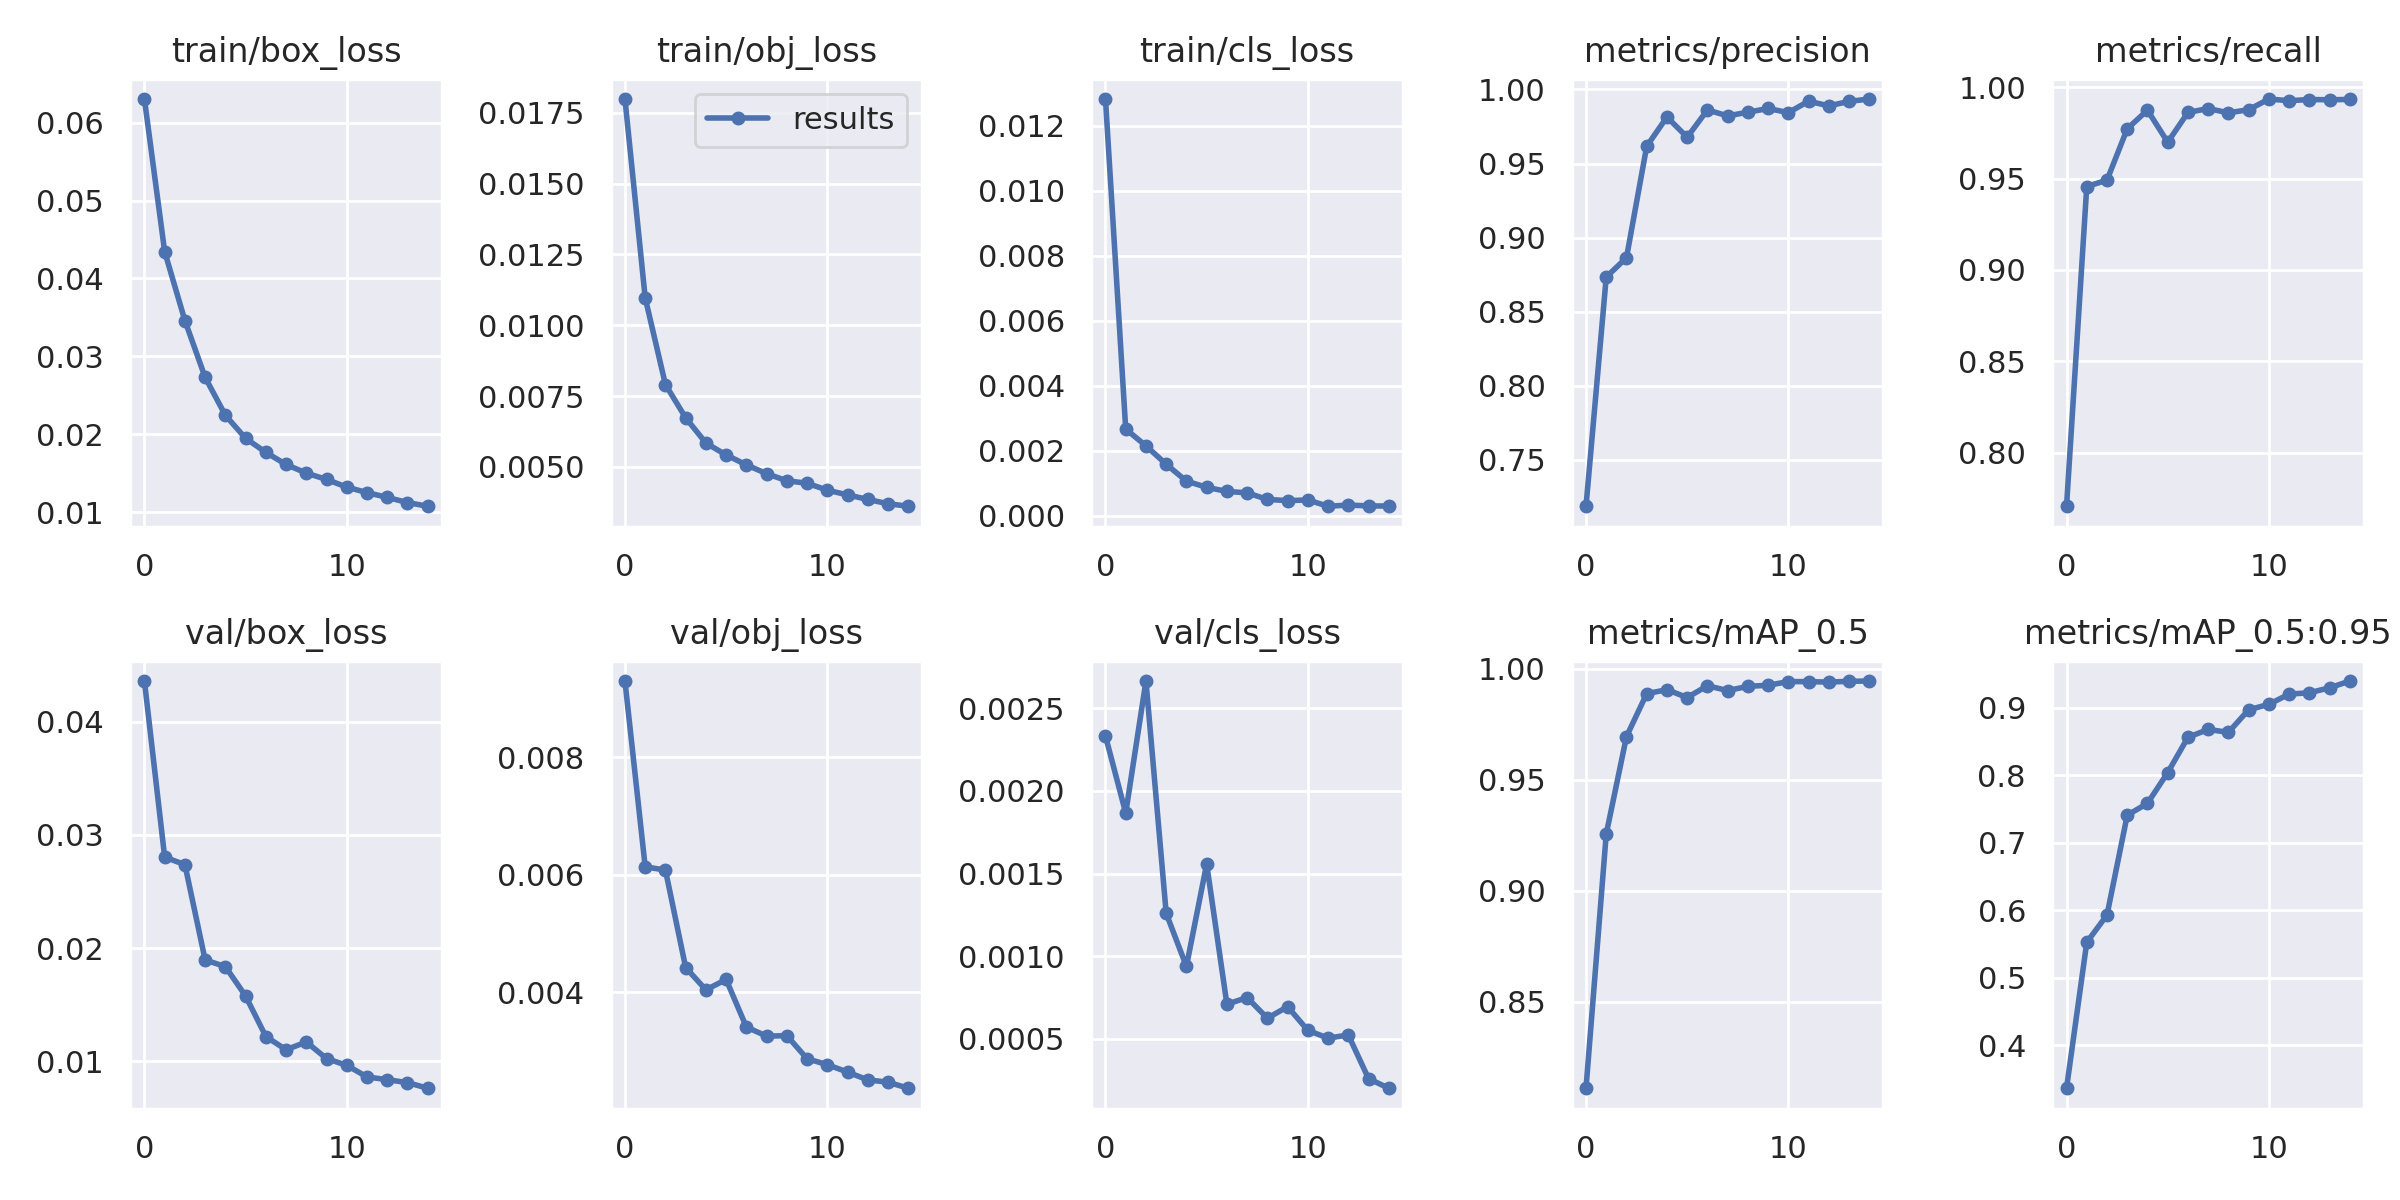

In [ ]:
Image(filename='/content/yolov5/runs/train/dataset_results/results.png',width=1000)

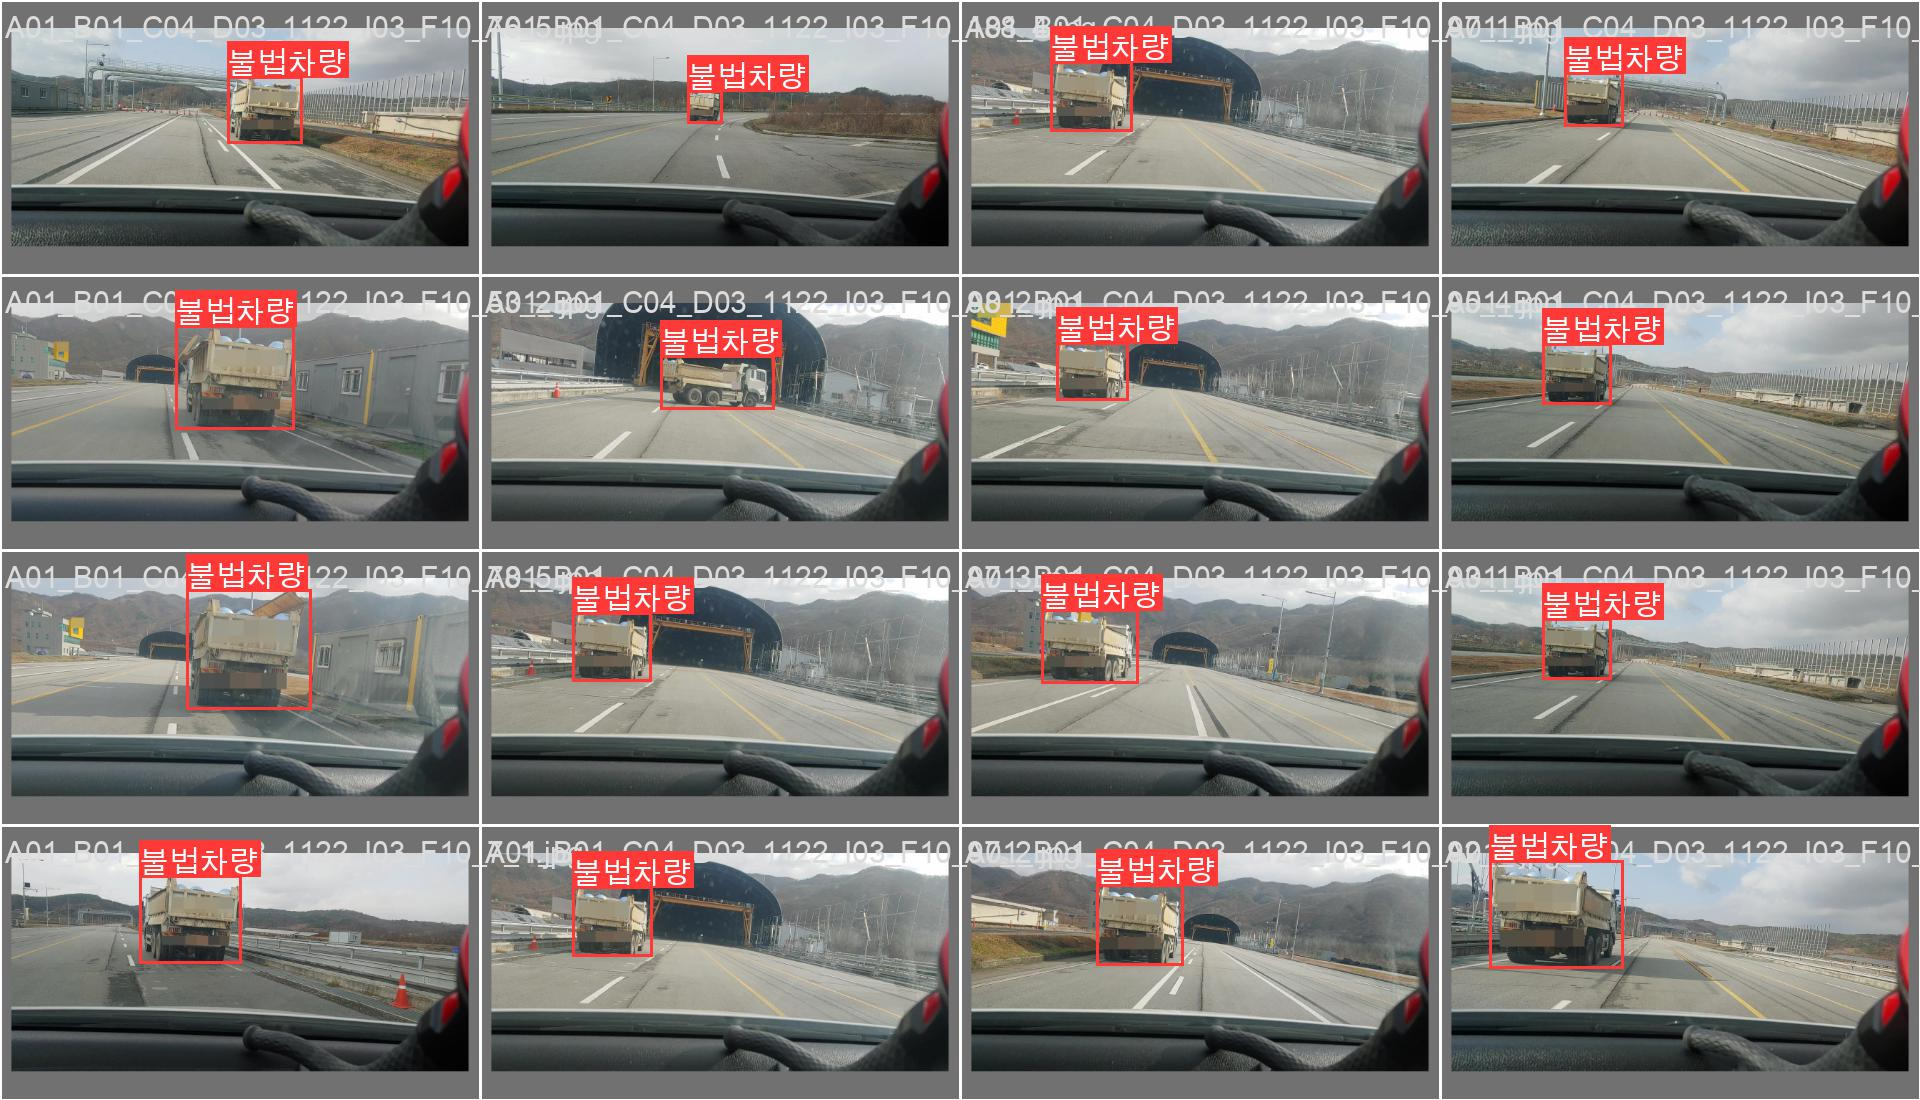

In [ ]:
Image(filename='/content/yolov5/runs/train/dataset_results/val_batch1_labels.jpg',width=1000)

In [ ]:
%%time
!python detect.py --weights runs/train/dataset_results/weights/best.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/sample.mp4

detect: weights=['runs/train/dataset_results/weights/best.pt'], source=/content/drive/MyDrive/sample.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5n summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
video 1/1 (1/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 11.4ms
video 1/1 (2/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 8.0ms
video 1/1 (3/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 7.9ms
video 1/1 (4/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 8.5ms
video 1/1 (5

## v5s훈련 및 결과

In [ ]:
!python train.py --img 640 --batch 64 --epochs 15 --data ./dataset/data.yaml --cfg ./models/custom_yolov5s.yaml --weights yolov5s.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=15, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.56, cls_pw=1.15, obj=0.742, obj_pw=0.946, iou_t=0.6, anchor_t=

In [ ]:
!python val.py --weights runs/train/dataset_results2/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100% 1049/1049 [00:00<?, ?it/s]
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_5.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_

### detect 수행 및 결과 이미지

In [ ]:
%%time
!python detect.py --weights runs/train/dataset_results2/weights/best.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/sample.mp4

detect: weights=['runs/train/dataset_results2/weights/best.pt'], source=/content/drive/MyDrive/sample.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 12.9ms
video 1/1 (2/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 9.9ms
video 1/1 (3/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 9.8ms
video 1/1 (4/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 9.9ms
video 1/1 

## v5m훈련 및 결과

In [ ]:
!python train.py --img 640 --batch 32 --epochs 15 --data ./dataset/data.yaml --cfg ./models/custom_yolov5m.yaml --weights yolov5m.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

train: weights=yolov5m.pt, cfg=./models/custom_yolov5m.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=15, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.56, cls_pw=1.15, obj=0.742, obj_pw=0.946, iou_t=0.6, anchor_t=

In [ ]:
!python val.py --weights runs/train/dataset_results6/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results6/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100% 1049/1049 [00:00<?, ?it/s]
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_5.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02

### detect수행 및 결과 이미지

In [ ]:
%%time
!python detect.py --weights runs/train/dataset_results6/weights/best.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/sample.mp4

detect: weights=['runs/train/dataset_results6/weights/best.pt'], source=/content/drive/MyDrive/sample.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
video 1/1 (1/915) /content/drive/MyDrive/sample.mp4: 448x640 (no detections), 22.7ms
video 1/1 (2/915) /content/drive/MyDrive/sample.mp4: 448x640 (no detections), 22.6ms
video 1/1 (3/915) /content/drive/MyDrive/sample.mp4: 448x640 (no detections), 22.3ms
video 1/1 (4/915) /content/drive/MyDrive/sample.mp4: 44

## v5l훈련 및 결과

In [ ]:
!python train.py --img 640 --batch 16 --epochs 15 --data ./dataset/data.yaml --cfg ./models/custom_yolov5l.yaml --weights yolov5l.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

train: weights=yolov5l.pt, cfg=./models/custom_yolov5l.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.56, cls_pw=1.15, obj=0.742, obj_pw=0.946, iou_t=0.6, anchor_t=

In [ ]:
!python val.py --weights runs/train/dataset_results9/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results9/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100% 1049/1049 [00:00<?, ?it/s]
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_5.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A0

### detect수행 및 결과 이미지

In [ ]:
%%time
!python detect.py --weights runs/train/dataset_results9/weights/best.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/sample.mp4

detect: weights=['runs/train/dataset_results9/weights/best.pt'], source=/content/drive/MyDrive/sample.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
video 1/1 (1/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 42.3ms
video 1/1 (2/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 42.0ms
video 1/1 (3/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 42.1ms
video 1/1 (4/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 39.7ms
video

## v5x훈련 및 결과

In [ ]:
!python train.py --img 640 --batch 16 --epochs 15 --data ./dataset/data.yaml --cfg ./models/custom_yolov5x.yaml --weights yolov5x.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

train: weights=yolov5x.pt, cfg=./models/custom_yolov5x.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.56, cls_pw=1.15, obj=0.742, obj_pw=0.946, iou_t=0.6, anchor_t=

In [ ]:
!python val.py --weights runs/train/dataset_results10/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results10/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100% 1049/1049 [00:00<?, ?it/s]
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_104_5.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A

### detect수행 및 결과 이미지

In [ ]:
%%time
!python detect.py --weights runs/train/dataset_results10/weights/best.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/sample.mp4

detect: weights=['runs/train/dataset_results10/weights/best.pt'], source=/content/drive/MyDrive/sample.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
video 1/1 (1/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 72.4ms
video 1/1 (2/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 62.9ms
video 1/1 (3/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 38.7ms
video 1/1 (4/915) /content/drive/MyDrive/sample.mp4: 448x640 1 정상차량, 38.0ms
vide

# 실제 모델 만들기


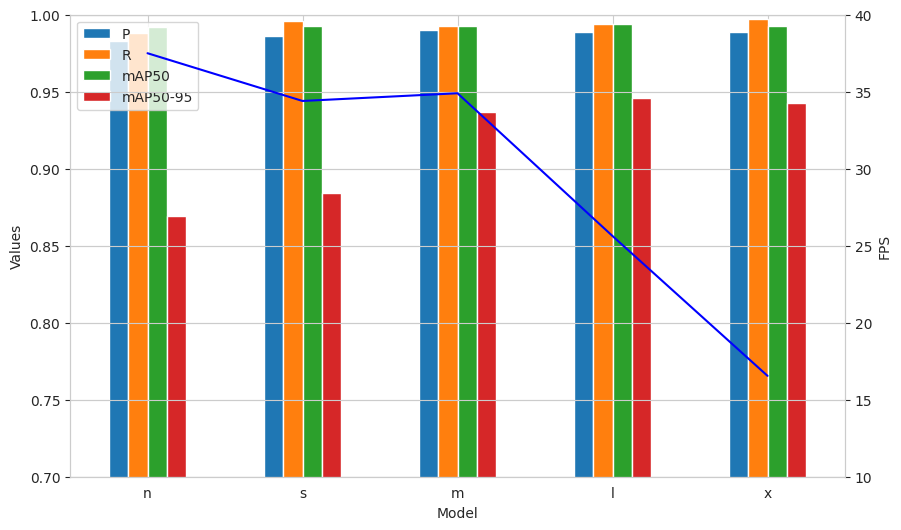

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 프레임 생성
data = {'P': [0.983, 0.986, 0.99, 0.989, 0.989],
        'R': [0.988, 0.996, 0.993, 0.994, 0.997],
        'mAP50': [0.992, 0.993, 0.993, 0.994, 0.993],
        'mAP50-95': [0.869, 0.884, 0.937, 0.946, 0.943],
        'FPS': [37.5, 34.4, 34.9, 25.63, 16.55]}
df = pd.DataFrame(data)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))
df.iloc[:, :-1].plot(kind='bar', ax=ax)
ax2 = ax.twinx()
df['FPS'].plot(ax=ax2, color='b')
ax.set_ylim([0.7, 1])
ax2.set_ylim([10, 40])

ax.set_ylabel('Values')
ax2.set_ylabel('FPS')
ax.set_xlabel('Model')
ax.set_xticklabels(['n','s','m','l','x'],rotation=0)

plt.show()

훈련이미지 2000장, 배경이미지 198장 epoch15로 훈련시켰을 때의 훈련 결과를 정리한 그래프이다.
위 그래프에서 파란선이 의미하는 것은 FPS로 비디오가 주어졌을 때 걸린 처리시간을 프레임 수에 나눈 것이다.

그래프를 살펴보면 v5m모델에서 mAP50-95지표가 급격히 오르고 이후 모델이 커지면 FPS가 급격히 떨어지는 것을 확인할 수 있었다. 따라서 FPS측면과 성능지표를 보았을 때 m모델이 가장 효율적이라 판단하여 m모델을 통하여 전체 데이터를 학습해서 모델을 만들었다.

In [ ]:
%%time
%cd yolov5 
!python train.py --img 640 --batch 32 --epochs 50 --data ./dataset/data.yaml --cfg ./models/custom_yolov5m.yaml --weights yolov5m.pt --name dataset_results --device 0 --hyp ./data/hyps/custom_hyp.yaml --cache

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
train: weights=yolov5m.pt, cfg=./models/custom_yolov5m.yaml, data=./dataset/data.yaml, hyp=./data/hyps/custom_hyp.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=dataset_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0111, lrf=0.01, momentum=0.953, weight_decay=0.00048, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.

In [ ]:
!python val.py --weights runs/train/dataset_results2/weights/best.pt --data ./dataset/data.yaml --img 640 --task test

val: data=./dataset/data.yaml, weights=['runs/train/dataset_results2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning /content/yolov5/dataset/test/labels.cache... 6310 images, 0 backgrounds, 0 corrupt: 100% 6310/6310 [00:00<?, ?it/s]
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_100_2.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02_B01_C01_D04_1118_I18_F07_103_1.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/yolov5/dataset/test/images/A02


# 가중치 파일 export

In [ ]:
%cd yolov5
!python export.py --weights runs/train/dataset_results2/weights/best.pt --include onnx --opset 12

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
export: data=data/coco128.yaml, weights=['runs/train/dataset_results2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/train/dataset_results2/weights/best.pt with output shape (1, 25200, 7) (40.2 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 r